### Loading libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import glob

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import *
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras import backend
sns.set_style("darkgrid")


### Plotting

In [3]:
def CalculateMetricsAndPlot(true_label, predicted_label,color="Blues",text="",is_show=True):
    if is_show:
        plt.rcParams['figure.figsize'] = [9, 6]
    CM = confusion_matrix(true_label, predicted_label)
    acc = round(accuracy_score(true_label,predicted_label)*100,2)
    precision = round(precision_score(true_label,predicted_label, average='macro'),2)
    if text == "":
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix (Test) | Accuracy={0}% | Precision={1}".format(acc,precision))
    else :
        sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix for (Test) | Accuracy={0}% | Precision={1} | {2}".format(acc,precision,text))
    if is_show:
        plt.show()

def TrainingPlot(_history,text=None,is_show=True):
    if is_show :
        plt.rcParams['figure.figsize'] = [15, 5]
    plt.subplot(1,2,1)
    plt.plot(_history["loss"],label="Train loss")
    plt.plot(_history["val_loss"],label="Validation loss")
    if not text is None:
        plt.title("Loss/Epoch | {0}".format(text))
    else:
        plt.title("Loss/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Crossentropy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(_history["acc"],label="Train accuracy")
    plt.plot(_history["val_acc"],label="Validation accuracy")
    if not text is None:
        plt.title("Accuracy/Epoch | {0}".format(text))
    else:
        plt.title("Accuracy/Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy in %")
    plt.legend()
  
    plt.tight_layout()
    if is_show:
        plt.show()
        
    plt.show()


### Loading dataset and pre-proccess

In [4]:
Files = glob.glob('./dataset/*.csv')
to_del_col = ["<TICKER>","<COl12>","<COl13>","<LAST>"]
dfs = []

# reading data
for file in Files: 
    all_data = open(file,"r",encoding="cp1252").readlines()
    df = pd.read_csv(file,encoding="utf16")
    
    # deleteing additional columns
    for col in to_del_col:
        if col in df.columns:
            df = df.drop(columns=[col])
            
    if "IRX6XTPI0009" in file :
        df.rename(columns={"<CLOSE>": "TPI-Close"},inplace=True)
        
    dfs.append(df)

# merging dataset
df = dfs [0]
for df_ in dfs[1:]:
    df = df.merge(df_, on='<DTYYYYMMDD>')
    
# select one year data
FinalDF = df.loc[df['<DTYYYYMMDD>'] >= 20210522].loc[ df['<DTYYYYMMDD>'] <= 20220522]
FinalDF.sort_values('<DTYYYYMMDD>',inplace=True)


### Create time steps dataset and check nan and normalize

In [5]:
def create_time_steps(n=3,normal_=True):
    global FinalDF
    df = FinalDF.copy()
    df.sort_values('<DTYYYYMMDD>',inplace=True)   
    df.reset_index(drop=True,inplace=True)
    
    if not all(pd.notnull(df)):
        raise ValueError("input data has nan values")
    
    df["Label"] = int(0.0)
    for index in range(df.shape[0]-1):
        df.loc[index,['Label']] = int(df.iloc[index+1]["TPI-Close"] >= df.iloc[index]["TPI-Close"])
     
    df.sort_values('<DTYYYYMMDD>',inplace=True)   
    df.reset_index(drop=True,inplace=True)    
    Label = df["Label"]
    
    df.drop(columns=["Label"],inplace=True)
    #df.drop(columns=['<DTYYYYMMDD>'],inplace=True)
    
    
    if normal_ :
        x = df.values 
        min_max_scaler = MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df = pd.DataFrame(x_scaled)
    
    Y = []
    X = []
    for index in range(n,df.shape[0]):
        X.append(df.iloc[index-n:index].to_numpy())
        Y.append(Label[index-1])
        
    return np.array(X),np.array(Y)

### dataset split

In [6]:
X_total,Y_total = create_time_steps(15,True)
X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.2, stratify=Y_total,shuffle=True)
X_train, X_valid, Y_train, Y_valid= train_test_split(X_train, Y_train, test_size=0.125, stratify=Y_train,shuffle=True)
print("Train Shap:",X_train.shape)


Train Shap: (155, 15, 129)


### Lstm maker

In [7]:
def get_lstm_gru(hidden:list,lstm=True,dr=0,bat=32):
    global X_total
    model = Sequential()
    model.add(Input(shape=X_total.shape[1:]))
    n = len(hidden)
    if n == 1:
        if lstm :
            model.add(LSTM(hidden[0],dropout=dr))
        else:
            model.add(GRU(hidden[0],dropout=dr))
    
    else:
        for index in range(n-1):
            if lstm :
                model.add(LSTM(hidden[index],return_sequences=True,dropout=dr))
            else:
                model.add(GRU(hidden[index],return_sequences=True,dropout=dr))
         
        if lstm :       
            model.add(LSTM(hidden[n-1],dropout=dr))
        else:
            model.add(GRU(hidden[n-1],dropout=dr))
    
    #model.add(Dense(10,activation="relu"))
    model.add(Dense(1,activation="sigmoid"))
    
    #opt = keras.optimizers.SGD(learning_rate=0.001,momentum=0.5)
    opt = keras.optimizers.Adam(learning_rate=0.00075)
    
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    return model
    

### Count of units tests in LSTM

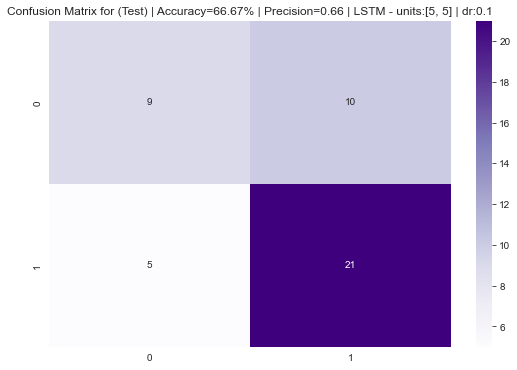

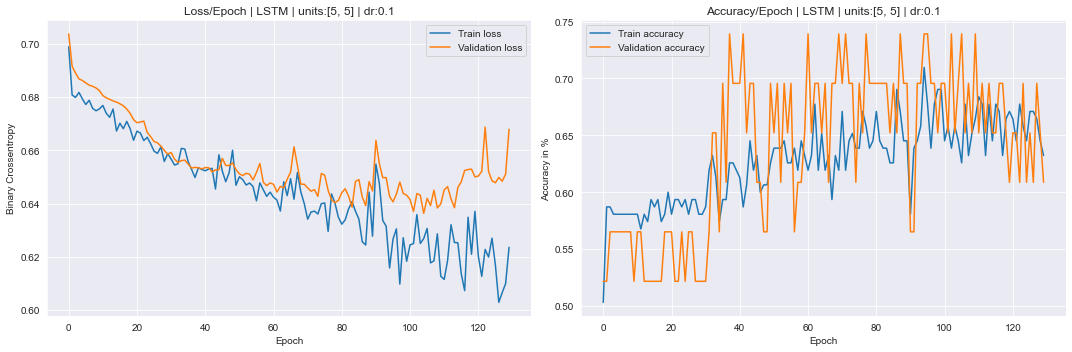

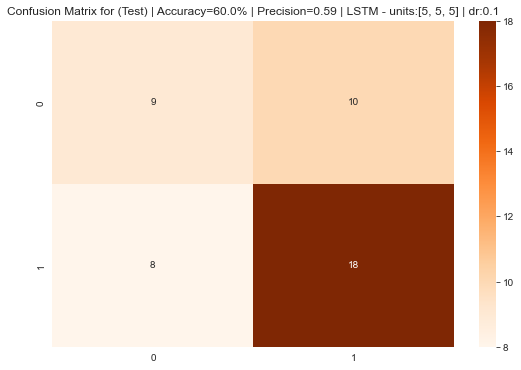

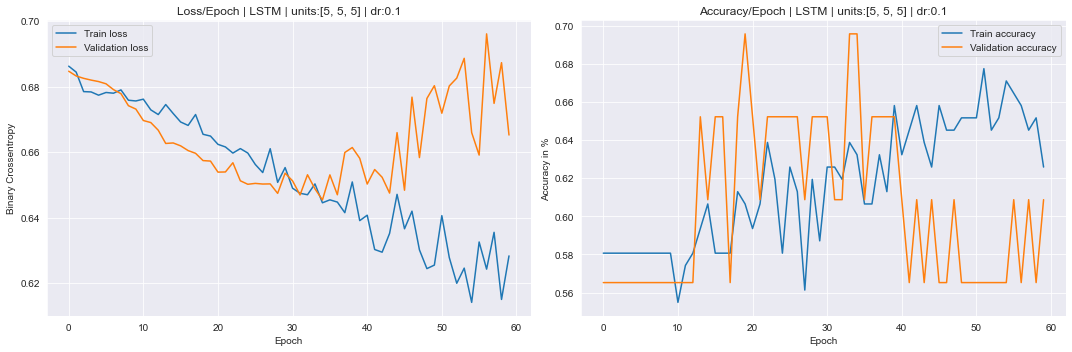

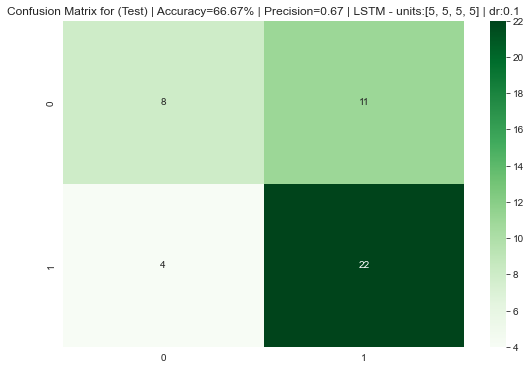

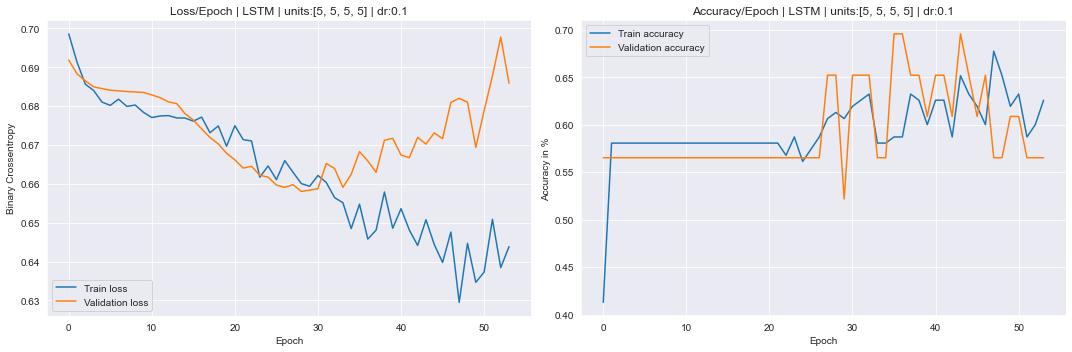

In [16]:
drs = [0.1]*4 #[0,0.05,0.1,0.15]
units = [[5,5],[5,5,5],[5,5,5,5]]#[1,5,10,15]
batch = 16
colors = ["Purples","Oranges","Greens","Reds"]

for index in range(3):
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, mode="min")   
    model = get_lstm_gru(units[index],True,dr=drs[index])
    History = model.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),epochs=300,verbose=0,batch_size=batch,callbacks=[callback])
    Y_pre = (model.predict(X_test) >= 0.5).astype(np.int8)
    CalculateMetricsAndPlot(Y_test,Y_pre,color=colors[index],text="LSTM - units:{0} | dr:{1}".format(units[index],drs[index]))
    TrainingPlot(History.history,text="LSTM | units:{0} | dr:{1}".format(units[index],drs[index]))

### Count of units tests in GRU

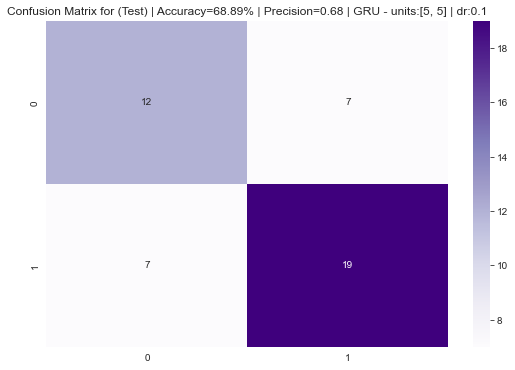

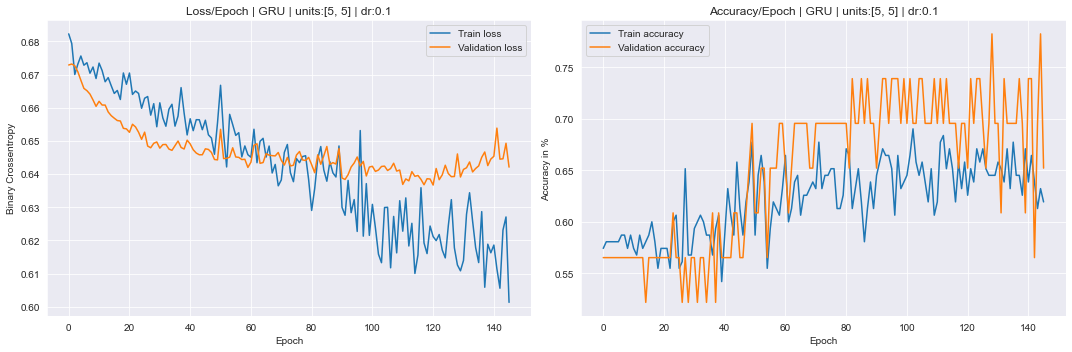

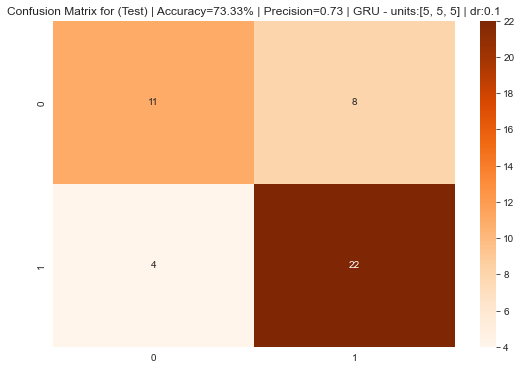

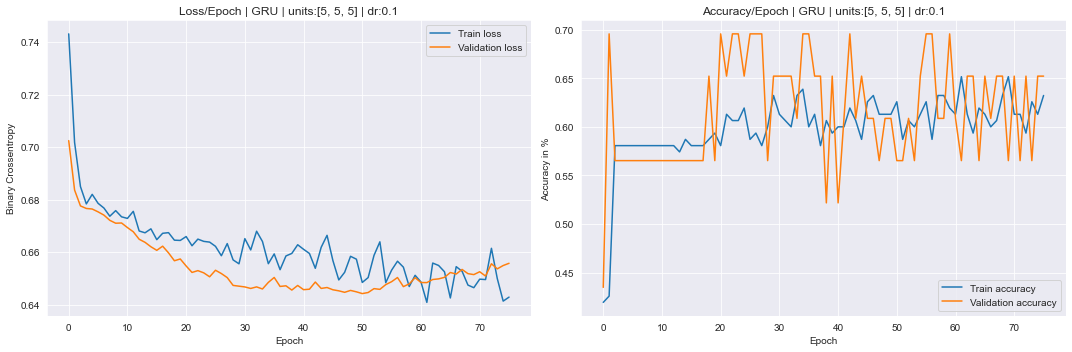

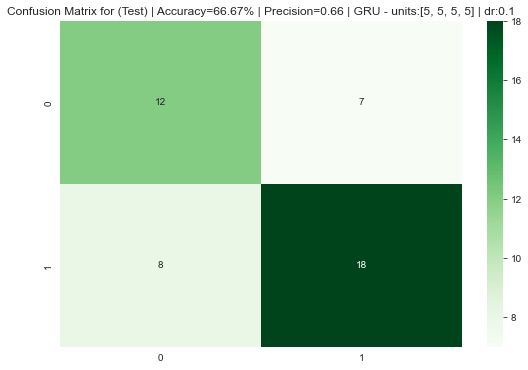

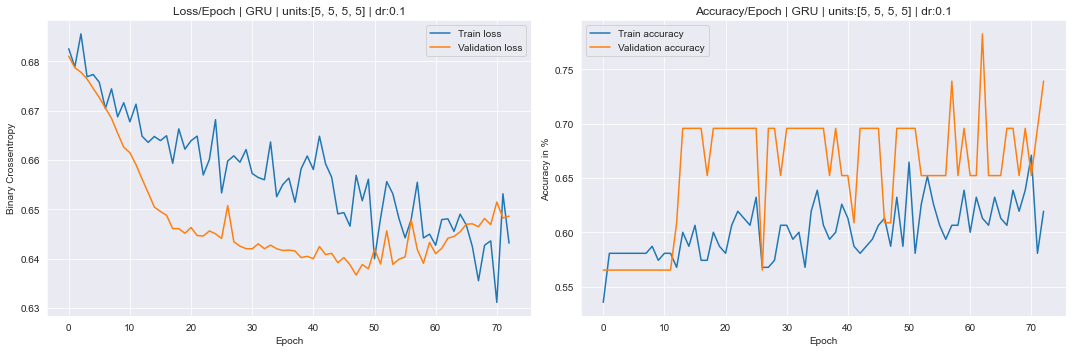

In [17]:
drs = [0.1]*4 #[0,0.05,0.1,0.15]
units = [[5,5],[5,5,5],[5,5,5,5]]#[1,5,10,15]
batch = 16
colors = ["Purples","Oranges","Greens","Reds"]

for index in range(3):
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, mode="min")   
    model = get_lstm_gru(units[index],False,dr=drs[index])
    History = model.fit(X_train,Y_train,validation_data=(X_valid,Y_valid),epochs=300,verbose=0,batch_size=batch,callbacks=[callback])
    Y_pre = (model.predict(X_test) >= 0.5).astype(np.int8)
    CalculateMetricsAndPlot(Y_test,Y_pre,color=colors[index],text="GRU - units:{0} | dr:{1}".format(units[index],drs[index]))
    TrainingPlot(History.history,text="GRU | units:{0} | dr:{1}".format(units[index],drs[index]))